https://www.kaggle.com/code/alaminbhuyan/mbert-fine-tuning

In [7]:
from IPython import display 
display.clear_output()

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import string
import pickle
import random

import transformers
from transformers import TFAutoModel, AutoTokenizer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Embedding, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             precision_score,
                             recall_score, f1_score,
                             classification_report, roc_auc_score, roc_curve)

!gdown 1FKopENMcHF5bAk6KQnCVJNulJK8awlmg

In [8]:
os.chdir('E:\Python code\IBM 文本分类数据')

file_name = 'IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()

# 1.3 Encode output column into binary
df.sentiment.replace('positive', 1, inplace=True)
df.sentiment.replace('negative', 0, inplace=True)

df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [9]:
df = df.rename(columns = {'sentiment':'target'})
df_ = df.head(5000)

In [10]:
df_.head(10)

,review,target
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [11]:
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text
df_['comments'] = df_['review'].apply(preprocess_text)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5128\3023609673.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['comments'] = df_['review'].apply(preprocess_text)


In [12]:
df_ = df_.drop(['review'],axis=1)
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   target    5000 non-null   int64 
 1   comments  5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [13]:
df2 = df_.copy()

df2["length"] = df2["comments"].str.split().str.len()

print("Maximum sentence length: ", df2['length'].max())
print("Minimum sentence length: ", df2['length'].min())
print("Average sentence length: ", df2['length'].mean())

Maximum sentence length:  921
Minimum sentence length:  8
Average sentence length:  119.8232


In [16]:
# 1. Load Pre-trained Model (e.g., mBERT)
model_name = "bert-base-multilingual-cased"  # Or you can use 'xlm-roberta-base' for better multilingual support

tokenizer = AutoTokenizer.from_pretrained(model_name)

bert_model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [17]:
# 2. Preprocess the data (tokenize and pad)
def preprocess_text(text, max_len=128):
    inputs = tokenizer(text, return_tensors="tf", padding='max_length', truncation=True, max_length=max_len)
    # inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=max_len)
    return inputs['input_ids'][0], inputs['attention_mask'][0]


# 3. Generate Embeddings using LLM
def generate_embeddings(input_ids, attention_masks):
    outputs = bert_model(input_ids, attention_mask=attention_masks)
    return outputs.last_hidden_state  # [batch_size, seq_length, hidden_size]

In [18]:
# Apply the tokenizer to each comment and store input IDs and attention masks in new DataFrame columns

df_[['input_ids', 'attention_masks']] = df_['comments'].apply(func=preprocess_text).apply(pd.Series)

In [19]:
df_.head()

,target,comments,input_ids,attention_masks
0,1,one reviewers mentioned watching 1 oz episode ...,"(tf.Tensor(101, shape=(), dtype=int32), tf.Ten...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."
1,1,wonderful little production filming technique ...,"(tf.Tensor(101, shape=(), dtype=int32), tf.Ten...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."
2,1,thought wonderful way spend time hot summer we...,"(tf.Tensor(101, shape=(), dtype=int32), tf.Ten...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."
3,0,basically theres family little boy jake thinks...,"(tf.Tensor(101, shape=(), dtype=int32), tf.Ten...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."
4,1,petter matteis love time money visually stunni...,"(tf.Tensor(101, shape=(), dtype=int32), tf.Ten...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."


In [20]:
df_.shape

(5000, 4)

In [21]:
# 4. Convert the DataFrame columns to numpy arrays for model input

input_ids = np.stack(df_['input_ids'].to_numpy())

attention_masks = np.stack(df_['attention_masks'].to_numpy())

labels = df_['target'].to_numpy()

In [22]:
# 5. Generate embeddings in batches to avoid OOM errors

batch_size = 32  # Adjust based on your GPU memory

embeddings = []

for i in range(0, len(input_ids), batch_size):
    batch_input_ids = input_ids[i : i + batch_size]
    batch_attention_masks = attention_masks[i : i + batch_size]
    batch_embeddings = generate_embeddings(batch_input_ids, batch_attention_masks)
    embeddings.append(batch_embeddings)
    print(i)
    i+=1

embeddings = np.concatenate(embeddings, axis=0)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992


In [23]:
embeddings.shape

(5000, 128, 768)

In [24]:
embeddings[0]

array([[-0.42282414,  0.17982967, -0.40054834, ...,  0.678508  ,
        -0.36087957,  0.0678547 ],
       [-0.774393  , -0.70881116,  0.6342145 , ...,  0.5490676 ,
        -0.20204979,  0.40472478],
       [-1.2206262 , -0.48474616,  0.6864661 , ..., -0.0485248 ,
        -0.05180671,  0.26628497],
       ...,
       [-0.0474051 ,  0.6888958 , -0.70242304, ...,  0.3187484 ,
        -0.6953158 , -0.4165709 ],
       [ 0.10923644,  0.37416288, -0.01010808, ...,  0.84457695,
        -0.20444886, -0.36240196],
       [-0.392273  ,  0.09075567, -0.26790908, ...,  0.5821568 ,
        -0.19494991, -0.01604565]], dtype=float32)

In [25]:
# 6. Split the data into train=70%, validation=15%, and test=15% sets

X_train_val, X_test, y_train_val, y_test = train_test_split(embeddings, labels, test_size=0.15, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

In [26]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3499, 128, 768)
y_train shape:  (3499,)
X_val shape:  (751, 128, 768)
y_val shape:  (751,)
X_test shape:  (750, 128, 768)
y_test shape:  (750,)


Create the model

In [27]:
# 5. Build Custom CNN Model
def build_cnn_model(input_shape, num_classes=1):
    model = Sequential()
    
    model.add(layer=Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    model.add(layer=MaxPooling1D(pool_size=2))
    
    model.add(layer=Conv1D(filters=64, kernel_size=3, activation='relu'))
    
    model.add(layer=GlobalMaxPooling1D())
    
    model.add(layer=Dropout(0.5))

    model.add(layer=Dense(units=64, activation='relu'))
    
    # model.add(layer=Dropout(0.5))
    
    model.add(layer=Dense(units=num_classes, activation='sigmoid'))  # Output layer for binary classification
    
    return model

In [28]:
folder_path = r"E:\Python code\IBM 文本分类数据\kaggle"

In [29]:
# 6. Compile the CNN Model
random.seed(a=41)
np.random.seed(seed=41)
tf.random.set_seed(seed=41)

input_shape = (X_train.shape[1], X_train.shape[2])  # Sequence length and embedding size

cnn_model = build_cnn_model(input_shape)

metrics = ['accuracy','Precision','Recall', 'AUC']

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# Add EarlyStopping technique so we can save the best model
# model_es = EarlyStopping(monitor='val_accuracy', min_delta=1e-11, patience=20, verbose=1, restore_best_weights=True)
# model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1)

# Automatically saves the best weights of the model, based on best val_accuracy
model_mcp = ModelCheckpoint(filepath=os.path.join(folder_path, "Best_CNN_model.keras"),
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)
# Save the training information or log
# training_history_log = CSVLogger(filename=os.path.join(folder_path, "Best_CNN_model1_info.csv"), separator=',', append=True)

# model.summary()

# plot_model(model=model1, to_file=os.path.join(folder_path, "modelDiagram.png"),
#            show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, show_trainable=True)

BATCH_SIZE = 32
NUM_EPOCHS = 70

# 7. Train the Model
model_history = cnn_model.fit(X_train, y_train, 
                              epochs=NUM_EPOCHS, 
                              batch_size=BATCH_SIZE,
                              validation_data=(X_val, y_val),
                              callbacks=[model_mcp])



Epoch 1/70


108/110 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6163 - precision: 0.6141 - recall: 0.6332 - auc: 0.6656
Epoch 1: val_accuracy improved from -inf to 0.68975, saving model to E:\Python code\IBM 文本分类数据\kaggle\Best_CNN_model.keras
110/110 [==============================] - 5s 22ms/step - loss: 0.6534 - accuracy: 0.6170 - precision: 0.6167 - recall: 0.6315 - auc: 0.6660 - val_loss: 0.5796 - val_accuracy: 0.6897 - val_precision: 0.7396 - val_recall: 0.5741 - val_auc: 0.7725
Epoch 2/70
108/110 [============================>.] - ETA: 0s - loss: 0.5397 - accuracy: 0.7289 - precision: 0.7321 - recall: 0.7283 - auc: 0.8033
Epoch 2: val_accuracy improved from 0.68975 to 0.71372, saving model to E:\Python code\IBM 文本分类数据\kaggle\Best_CNN_model.keras
110/110 [==============================] - 1s 12ms/step - loss: 0.5406 - accuracy: 0.7282 - precision: 0.7306 - recall: 0.7286 - auc: 0.8024 - val_loss: 0.5832 - val_accuracy: 0.7137 - val_precision: 0.6688 

In [49]:
def plot_graph(history):
    # Accuracy
    plt.figure(figsize=(7, 4))
    plt.plot(history.history["accuracy"], color="red", label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], color="green", label="Val Accuracy")
    plt.title(label="Training & Validation Accuracy", fontsize=10)
    plt.xlabel(xlabel="Number of Epochs")
    plt.ylabel(ylabel="Accuracy")
    plt.legend()
    plt.grid(visible=True)
#     plt.savefig(os.path.join(folder_path, "train&val_acc.png"))
    plt.show()

    # Loss
    plt.figure(figsize=(7, 4))
    plt.plot(history.history["loss"], color="red", label="Training Loss")
    plt.plot(history.history["val_loss"], color="green", label="Validation Loss")
    plt.title(label="Training & Validation Loss", fontsize=10)
    plt.xlabel(xlabel="Number of Epochs")
    plt.ylabel(ylabel="Loss")
    plt.legend()
    plt.grid(visible=True)
#     plt.savefig(os.path.join(folder_path, "train&val_loss.png"))
    plt.show()

    # Precision
    plt.figure(figsize=(7, 4))
    plt.plot(history.history["precision"], color="red", label="Training Precision")
    plt.plot(history.history["val_precision"], color="green", label="Validation Precision")
    plt.title(label="Training and Validation Precision", fontsize=10)
    plt.xlabel(xlabel="Number of Epochs")
    plt.ylabel(ylabel="Precision")
    plt.legend()
    plt.grid(visible=True)
#     plt.savefig(os.path.join(folder_path, "train&val_precision.png"))
    plt.show()

    # Precision
    plt.figure(figsize=(7, 4))
    plt.plot(history.history["recall"], color="red", label="Training Recall")
    plt.plot(history.history["val_recall"], color="green", label="Validation Recall")
    plt.title(label="Training and Validation Recall", fontsize=10)
    plt.xlabel(xlabel="Number of Epochs")
    plt.ylabel(ylabel="Recall")
    plt.legend()
    plt.grid(visible=True)
#     plt.savefig(os.path.join(folder_path, "train&val_recall.png"))
    plt.show()

    # AUC
    plt.figure(figsize=(7, 4))
    plt.plot(history.history["auc"], color="red", label="Training AUC")
    plt.plot(history.history["val_auc"], color="green", label="Validation AUC")
    plt.title(label="Training and Validation AUC", fontsize=10)
    plt.xlabel(xlabel="Number of Epochs")
    plt.ylabel(ylabel="AUC")
    plt.legend()
    plt.grid(visible=True)
#     plt.savefig(os.path.join(folder_path, "train&val_auc.png"))
    plt.show()

def plot_confusion_matrix(y_true, y_pred, target_classes=None):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    matrix = pd.DataFrame(data=cm)
    if target_classes is not None:
        sns.heatmap(data=matrix, annot=True, fmt="d", cmap=plt.cm.magma, cbar=False, xticklabels=target_classes, yticklabels=target_classes)
    else:
        sns.heatmap(data=matrix, annot=True, fmt="d", cmap=plt.cm.magma, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
#     plt.savefig(os.path.join(folder_path, "confusionMatrix.png"))
    plt.show()

def plot_roc_curve(y_true, y_pred, model_name="Model"):
    rocAuc = roc_auc_score(y_true=y_true, y_score=y_pred)
    # print(rocAuc)
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_pred)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr , tpr , color='navy', label='ROC', marker='o')
    plt.plot([0, 1], [0, 1], color = 'red', linestyle='--', label='ROC curve(area = %0.2f)' % rocAuc)
    plt.xlabel(xlabel='False Positive Rate (FPR)')
    plt.ylabel(ylabel='True Positive Rate (TPR)')
    plt.title(label=f'ROC Curve of {model_name}') # Receiver Operating Characterstics (ROC)
    plt.legend()
#     plt.savefig(os.path.join(folder_path, "roc_curve.png"))
    plt.show()

def model_evaluation_info(y_true, y_pred):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    report = classification_report(y_true=y_true, y_pred=y_pred)

    # Print the results
    print("Test Accuracy:", round(accuracy, 5) * 100)
    print("Test Precision:", round(precision, 5) * 100)
    print("Test Recall:", round(recall, 5) * 100)
    print("Test F1-Score:", round(f1, 5) * 100)
    print("Classification Report:\n", report)

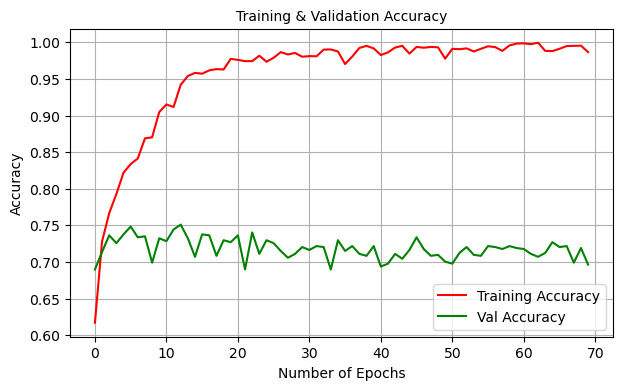

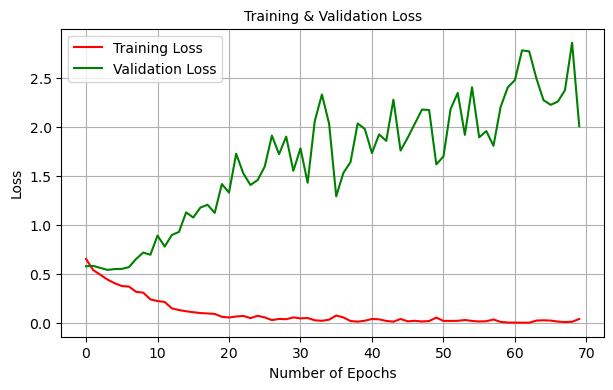

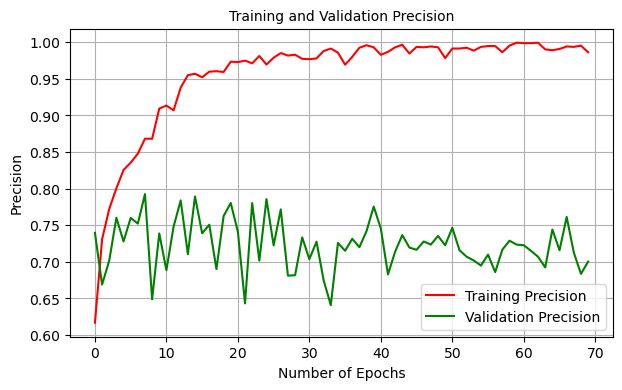

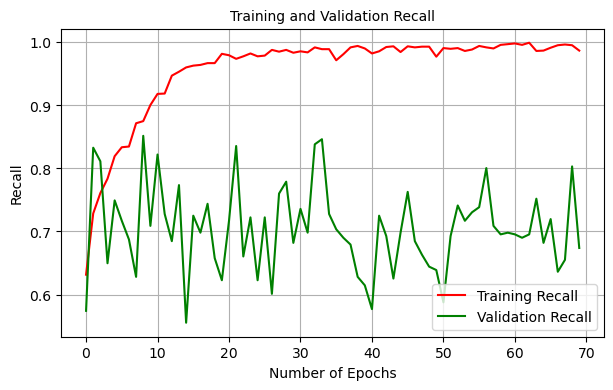

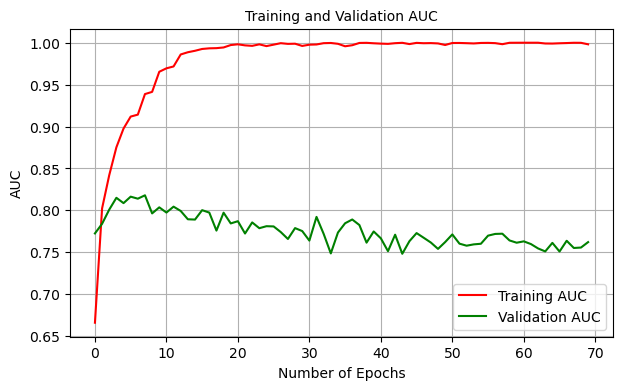

In [50]:
plot_graph(history=model_history)

In [53]:
cnn_model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 5ms/step - loss: 1.9066 - accuracy: 0.7200 - precision: 0.6731 - recall: 0.7292 - auc: 0.7756


[1.9065524339675903,
 0.7200000286102295,
 0.6730769276618958,
 0.7291666865348816,
 0.7755815982818604]

In [55]:
y_pred1 = (cnn_model.predict(x=X_test) > 0.6)
print("Before", y_pred1[: 10])

# Convert boolean array to 0 and 1 array

# Method 1: Using boolean indexing
# bool_array_as_int = y_pred1.astype(int)

# Method 2: Using casting (astype)
y_pred1 = y_pred1 * 1  # Multiplying by 1 casts True to 1 and False to 0

print("After", y_pred1[:10])

24/24 [==============================] - 0s 4ms/step
Before [[False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]]
After [[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]


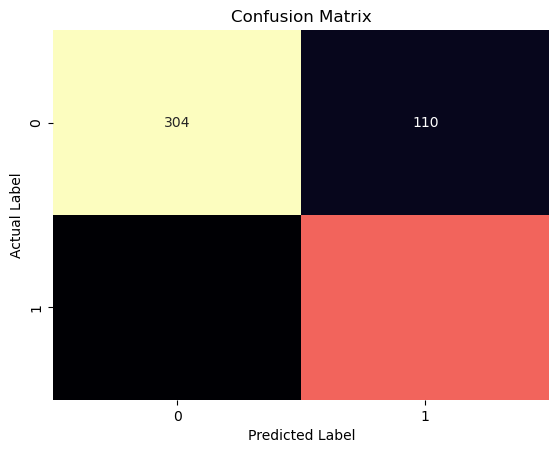

In [56]:
# Ploating the confusion matrix

plot_confusion_matrix(y_true=y_test, y_pred=y_pred1)

In [57]:
model_evaluation_info(y_true=y_test, y_pred=y_pred1)

Test Accuracy: 72.13300000000001
Test Precision: 68.30000000000001
Test Recall: 70.536
Test F1-Score: 69.39999999999999
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       414
           1       0.68      0.71      0.69       336

    accuracy                           0.72       750
   macro avg       0.72      0.72      0.72       750
weighted avg       0.72      0.72      0.72       750



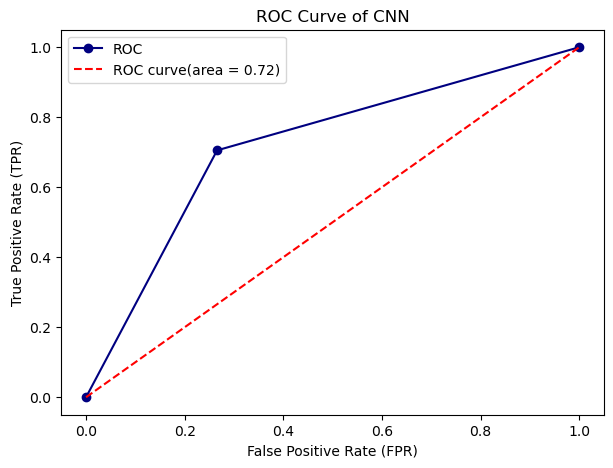

In [58]:
plot_roc_curve(y_true=y_test, y_pred=y_pred1, model_name="CNN")